In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [3]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [4]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !dnf --repo=rawhide repoquery --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in exceptions:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [5]:
with open("pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

## Exceptions

Get groups from portingdb

In [6]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh)

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Get all non-hidden source RPM packages (have an exception)

In [7]:
source_packages = []
for srpm, info in groups.items():
    if info.get("hidden", False):
        continue
    for package in info["packages"]:
        source_packages.append(package)

Get mapping from portingdb to get binary RPMs from source RPMs

In [8]:
with open("/home/lbalhar/Dropbox/Projekty/portingdb/_check_drops/results-sources.json") as fh:
    mapping = json.load(fh)

In [9]:
binary_packages = []
for package in source_packages:
    binary_packages.extend(mapping[package])

Final list of packages with approved exception

In [10]:
exceptions = binary_packages

In [11]:
exceptions.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1

In [12]:
exceptions.append("python3-dmidecode")  # Vztah "python3-dmidecode → python2-libxml2" je třeba odebrat, protože jde o stejný problém jako u capstone (python3-dmidecode requiruje libxml2mod.so()(64bit), to je providované oběma pythonX-libxml2).

## Wave #1 - packages directly depending on python2 package or on /usr/bin/python2 or python(abi) = 2.7

In [13]:
waves = {}

In [14]:
python27 = !dnf --repo=rawhide repoquery --qf "%{NAME}" --whatrequires python27 2> /dev/null

In [15]:
waves[1] = set([p for p in python27 if p not in exceptions])

In [16]:
g = nx.DiGraph()
node_colors = []

In [17]:
g.add_nodes_from(waves[1])

In [18]:
for package in waves[1]:
    g.add_edge(package, "PYTHON2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [19]:
len(waves[1])

505

## Wave 2, 3, 4, …

In [20]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# sugar-ruler
# gnome-python2-gnomekeyring
# sugar-speak
# python2-pyxattr
# python2-tbgrep
# sugar-finance
# macromilter
A glpi → macromilter
A iipsrv → macromilter
A php-horde-horde → macromilter
# gnome-python2-canvas
A gnome-python2-desktop → gnome-python2-canvas
# libsearpc
A libsearpc-devel → libsearpc
A seafile-client → libsearpc
# python2-pbr
# boost-python2
A boost-python2-devel → boost-python2
# python2-gtkextra
A audit-viewer → python2-gtkextra
# sugar-playgo
# sugar-labyrinth
# lilypond
A asciidoc-music → lilypond
A denemo → lilypond
A frescobaldi → lilypond
A python3-music21 → lilypond
# magicor
# nicotine+
# python2-fuse
# python2-gobject
A fleet-commander-client → python2-gobject
A gnome-transliteration → python2-gobject
A input-pad → python2-gobject
A python2-gobject-devel → python2-gobject
# dblatex
A asciidoc-latex → dblatex
# gst-entrans
# python2-pp
# python2-dpkt
# python2-setuptools_scm
# trac-iniadmin-plugin
# fishpoke
A fishpoll → fishpoke
# pyth

## Save

In [21]:
nx.write_adjlist(g, "full_graph.adjlist")

In [22]:
waves[1] = list(waves[1])

In [23]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [24]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [25]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [26]:
"PYTHON2" in g.nodes

True

## Graph manipulation

In [27]:
g_nc = g.copy()
g_nc

### Remove central node and isolated nodes

In [28]:
g_nc.remove_node("PYTHON2")

In [29]:
isolates = list(nx.isolates(g_nc))
g_nc.remove_nodes_from(isolates)

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


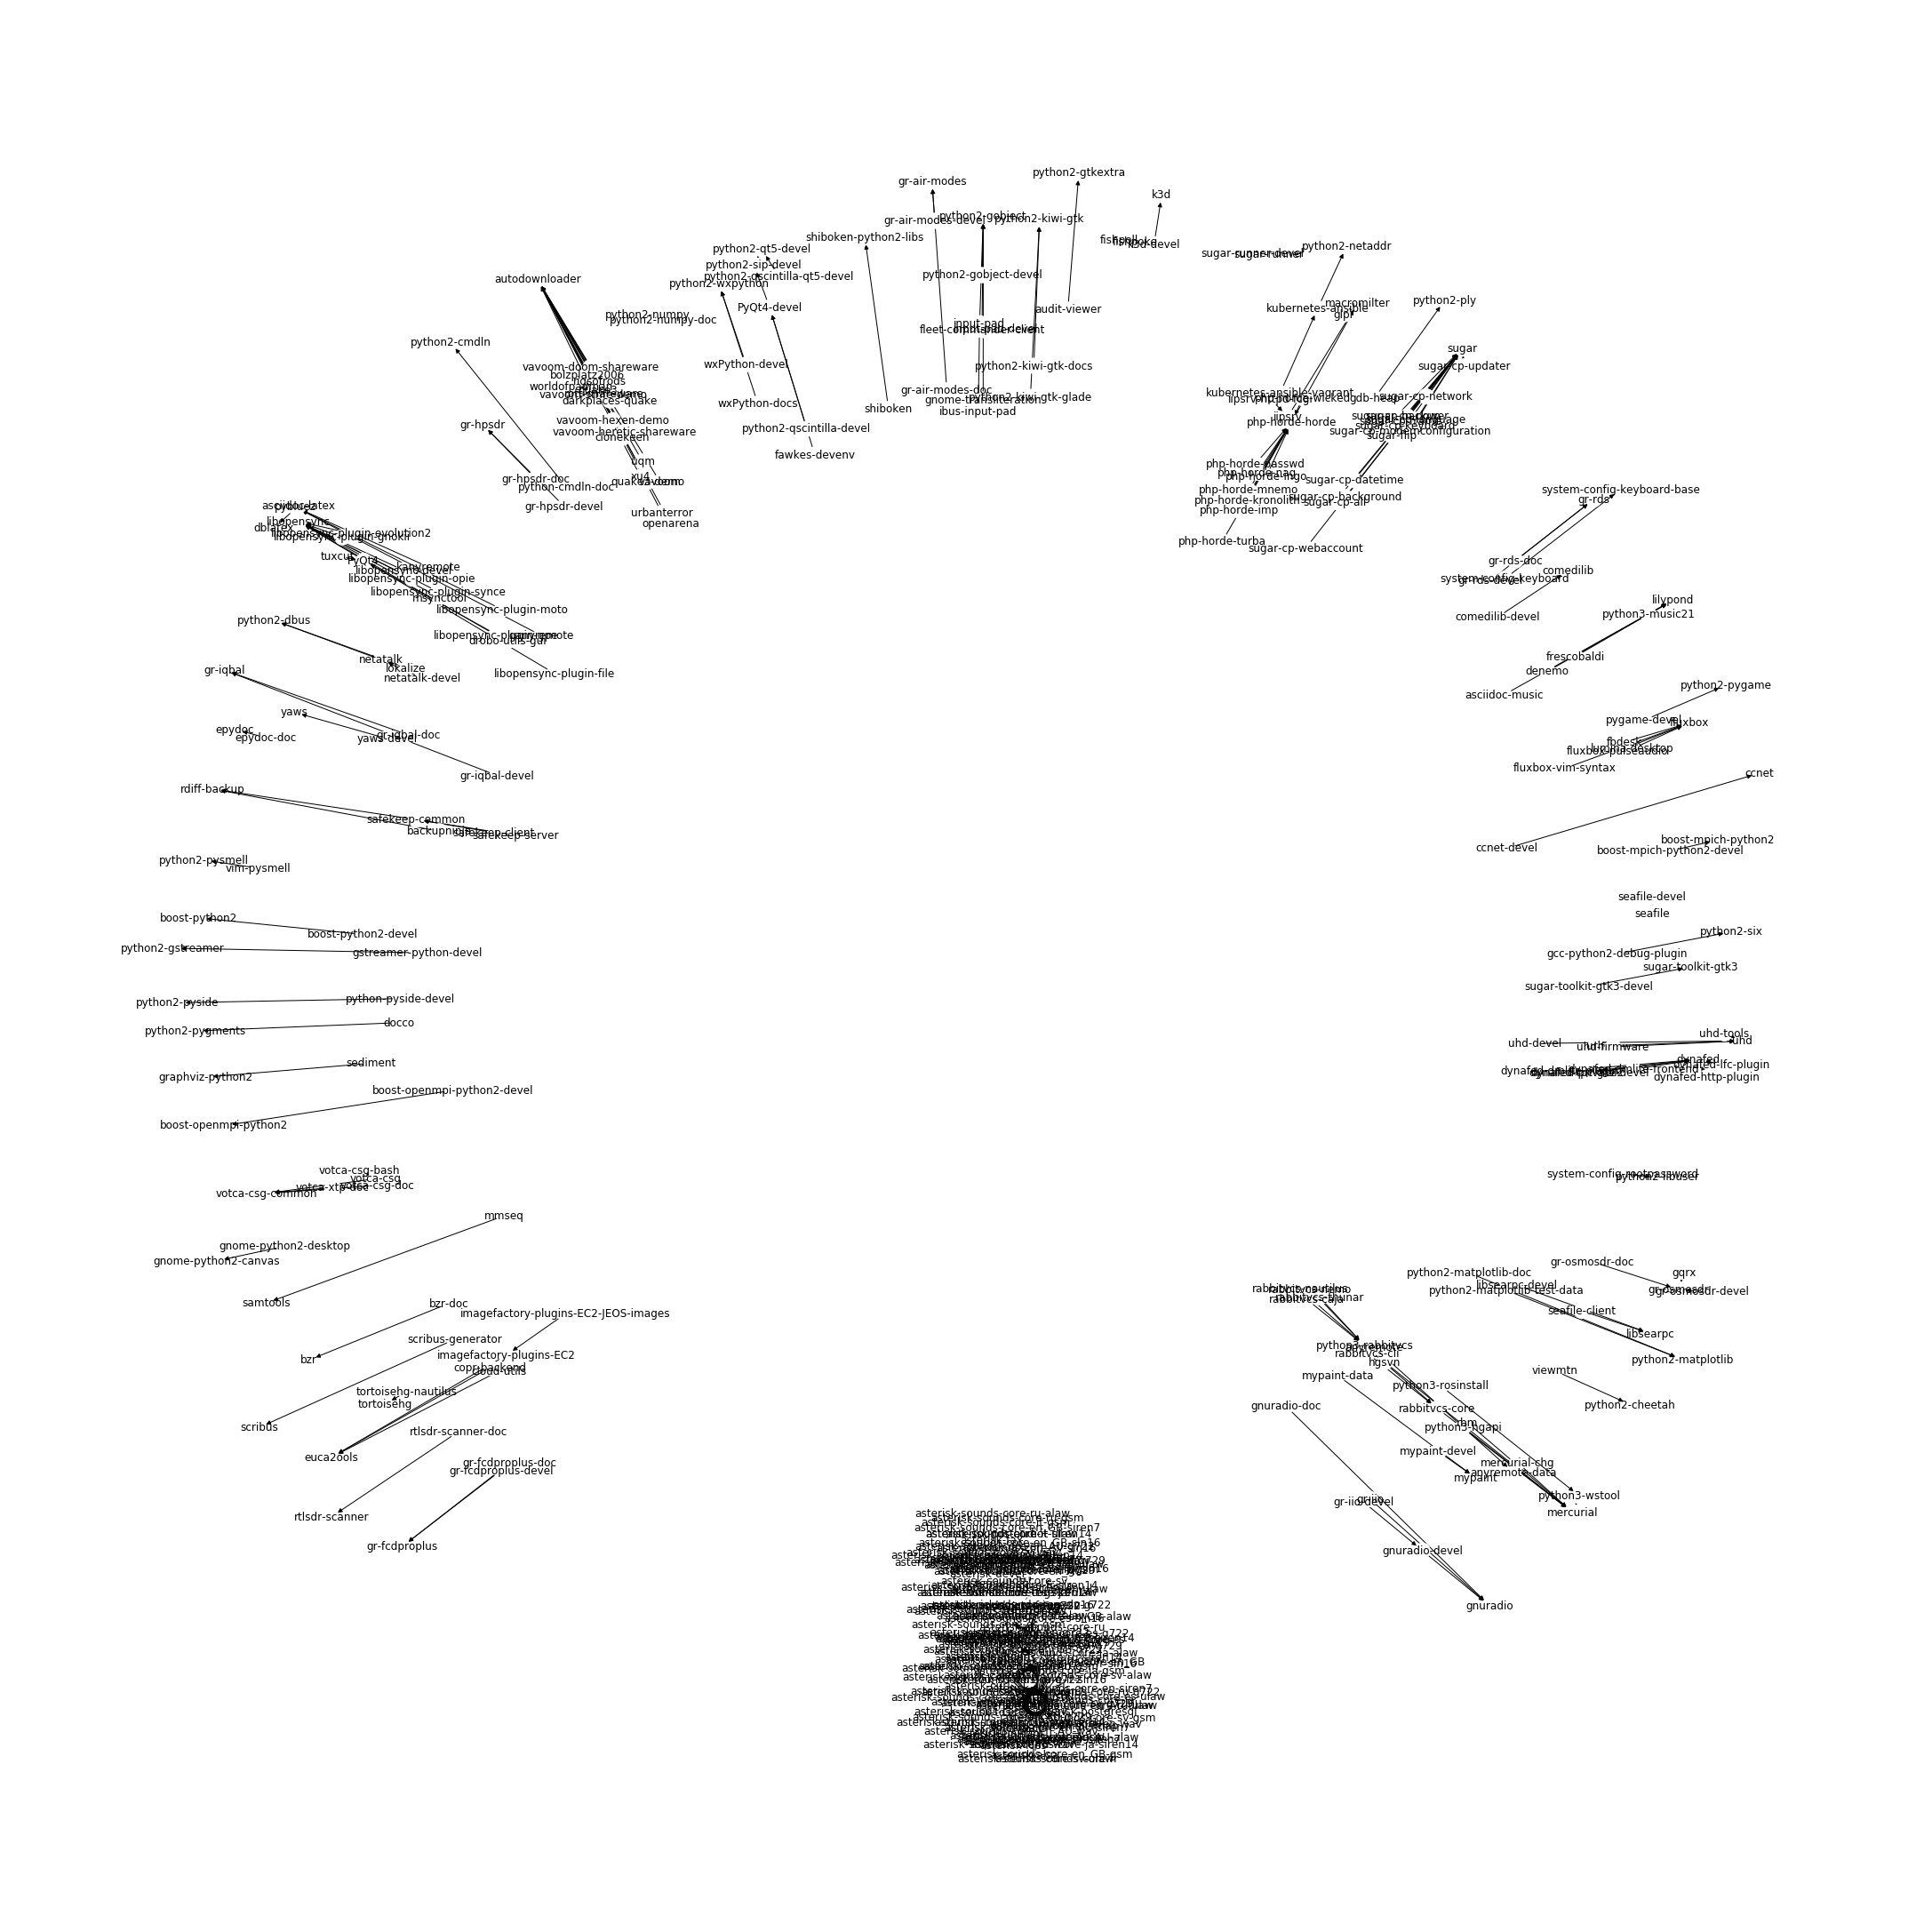

In [30]:
plt_draw(g_nc)

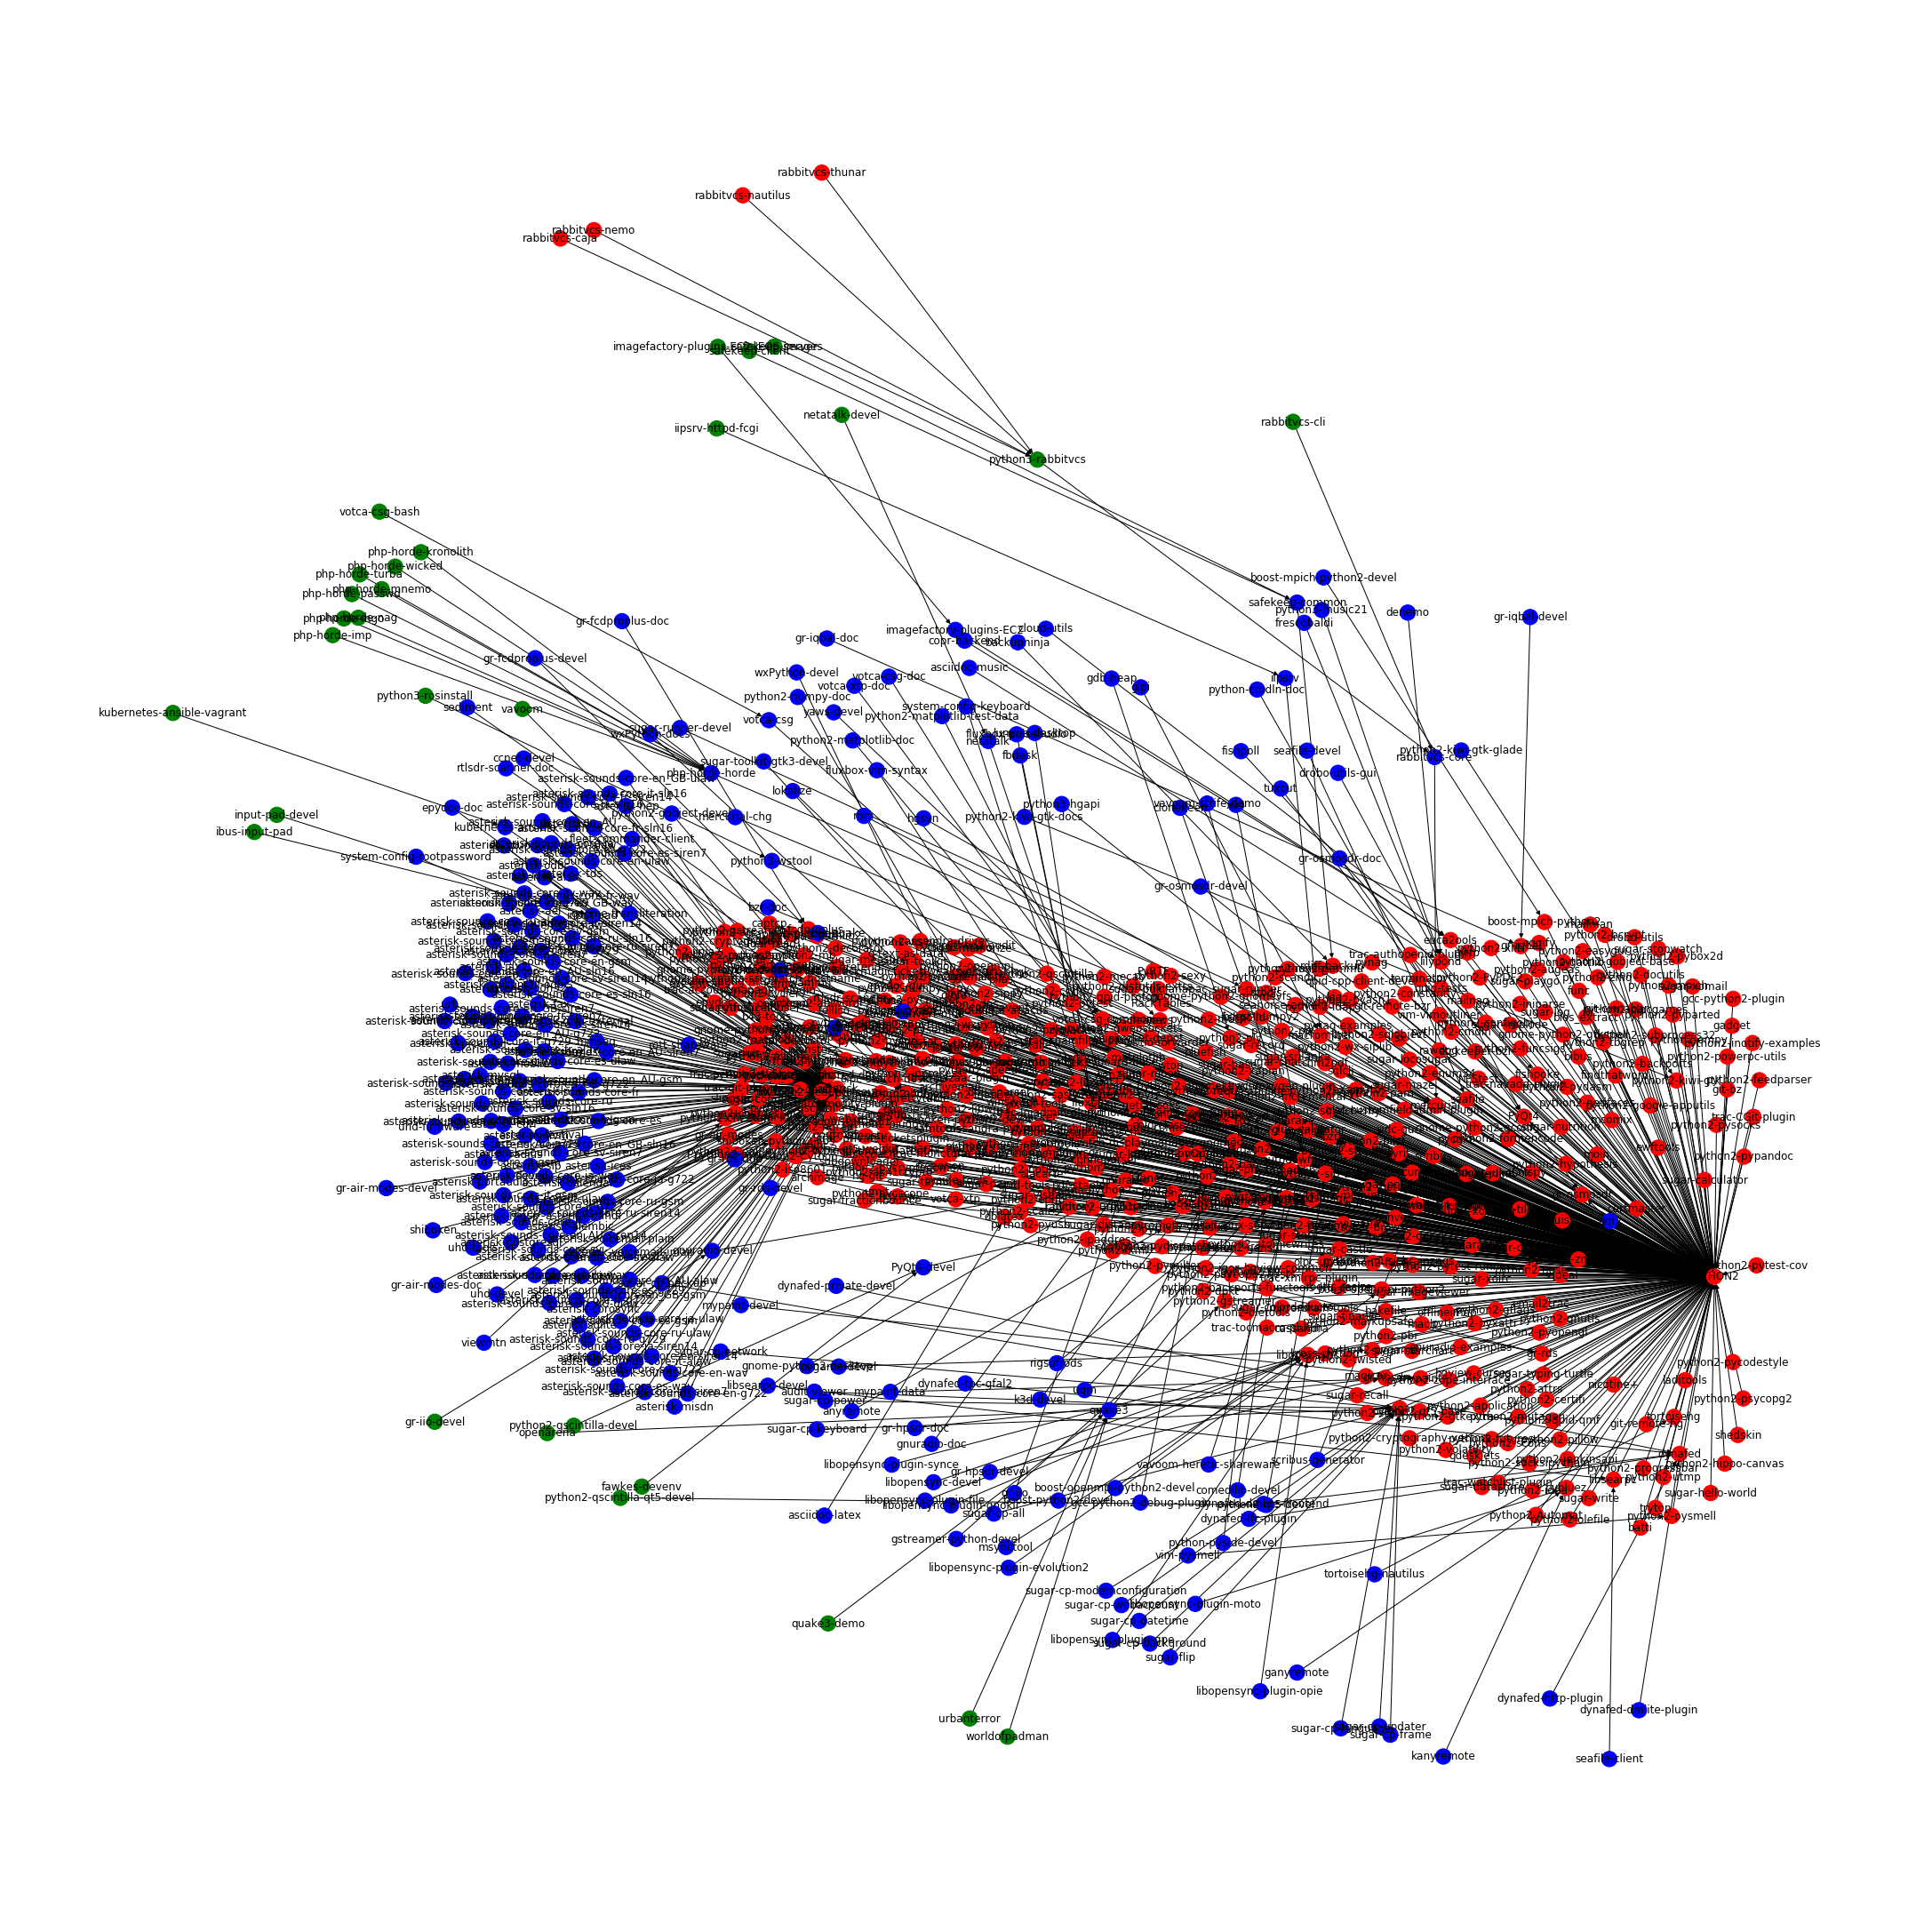

In [31]:
plt_draw(g, node_colors)

In [32]:
from networkx.algorithms.simple_paths import all_simple_paths
list(all_simple_paths(g, "rabbitvcs-nemo", "PYTHON2"))

[['rabbitvcs-nemo',
  'python3-rabbitvcs',
  'rabbitvcs-core',
  'mercurial',
  'PYTHON2']]

/home/lbalhar/.virtualenvs/python2_removal/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


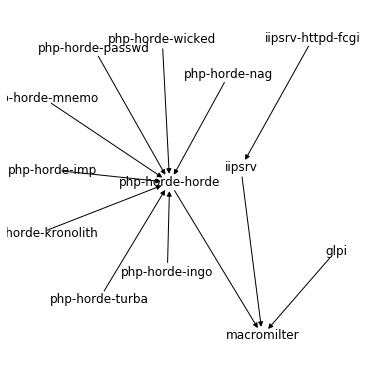

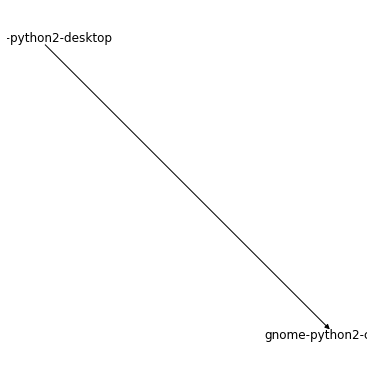

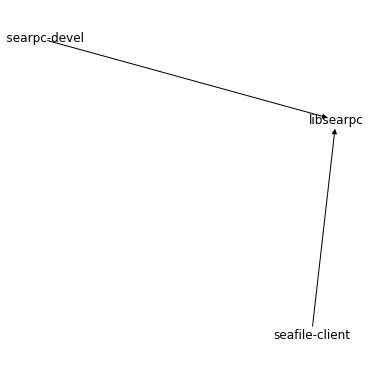

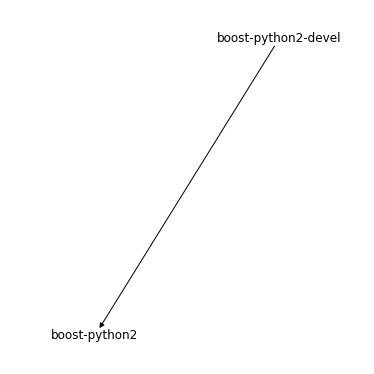

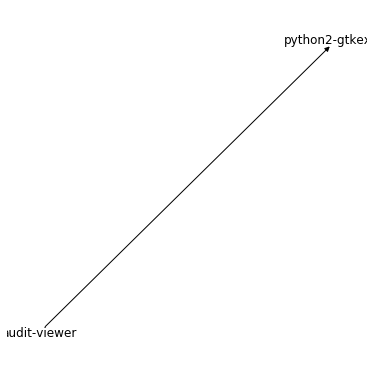

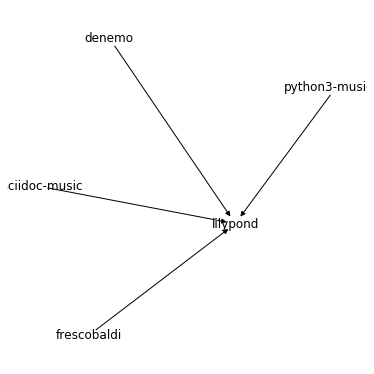

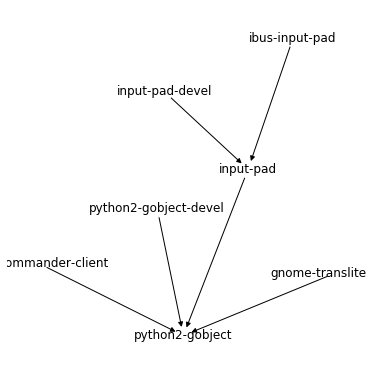

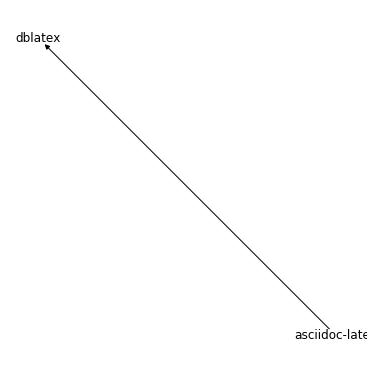

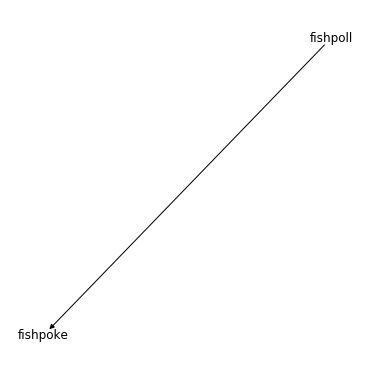

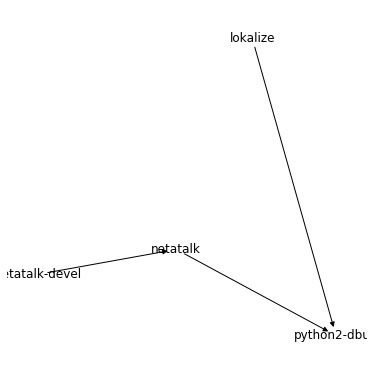

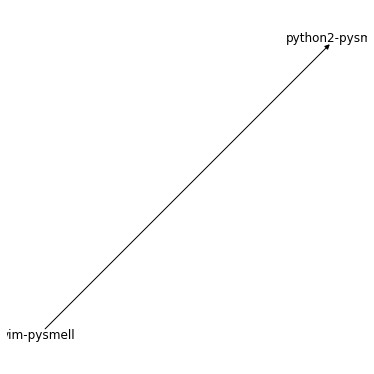

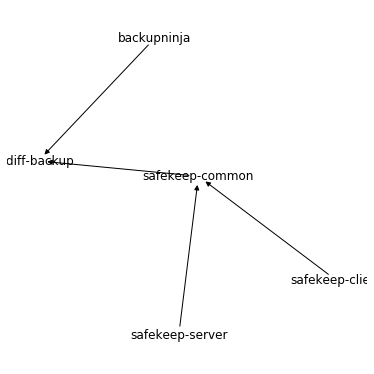

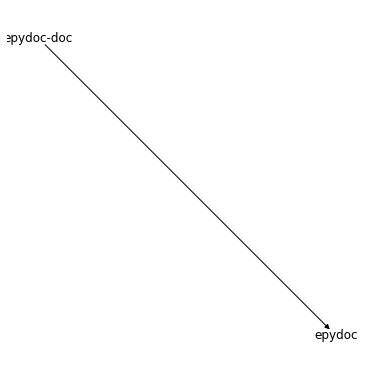

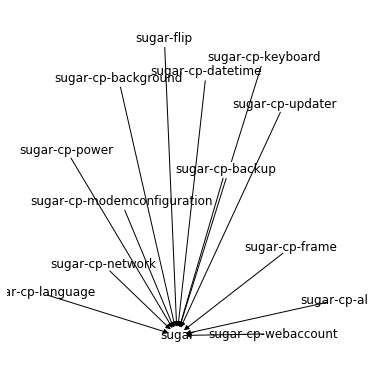

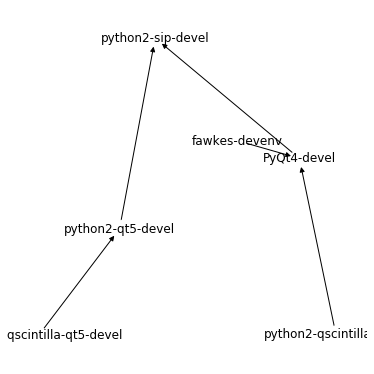

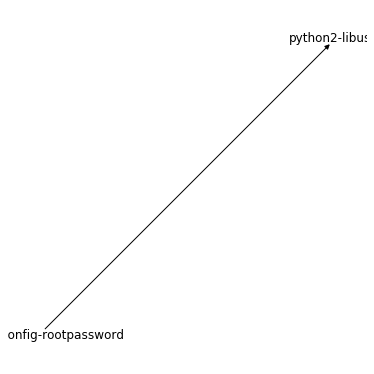

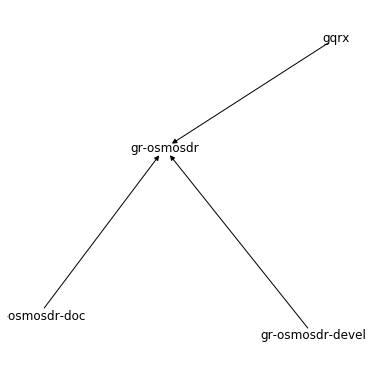

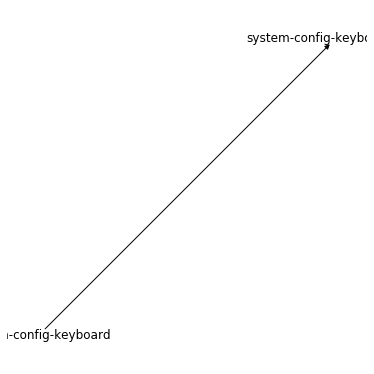

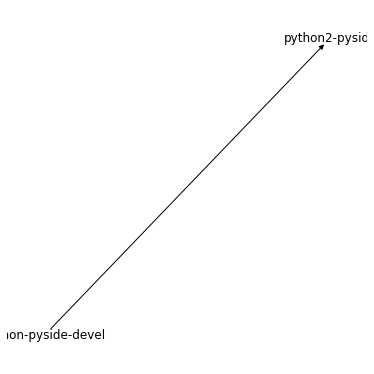

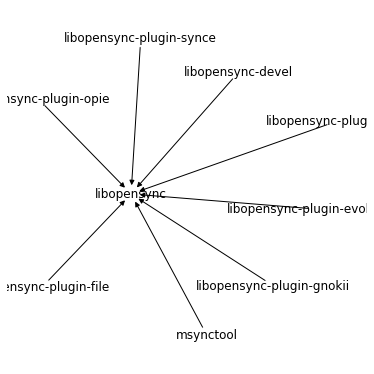

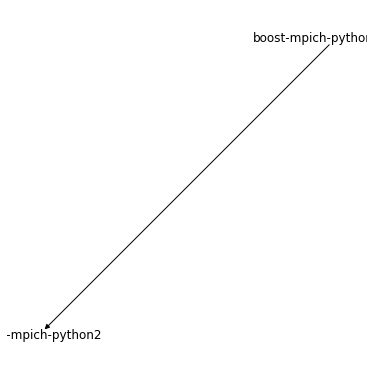

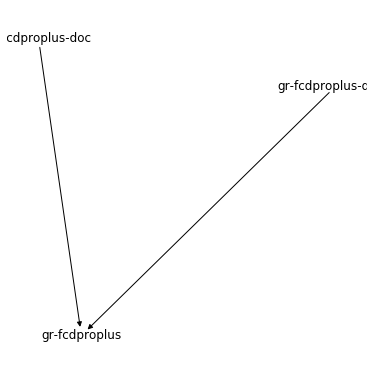

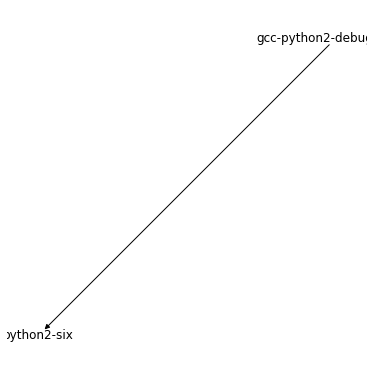

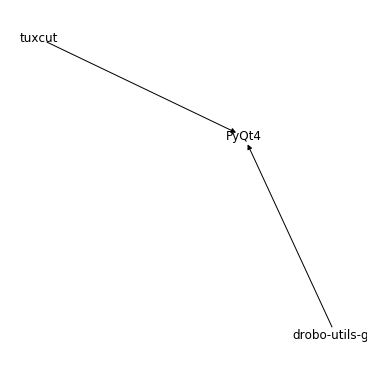

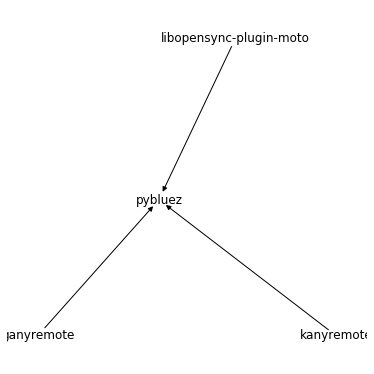

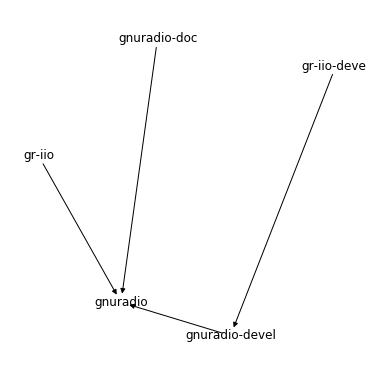

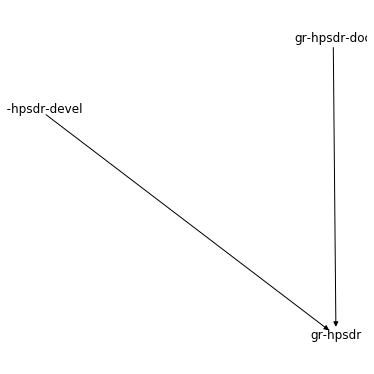

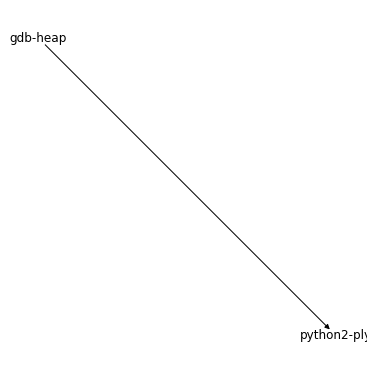

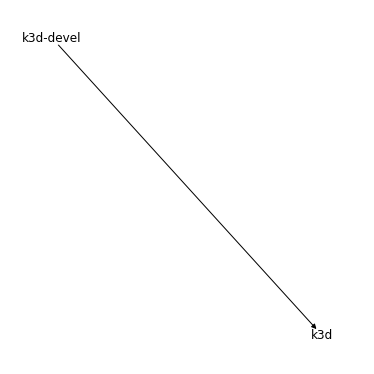

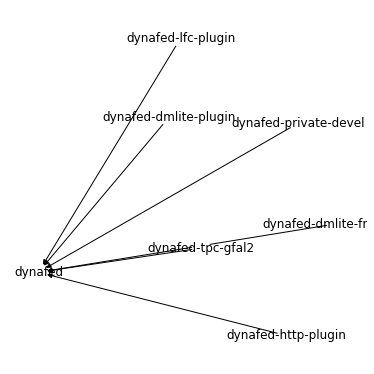

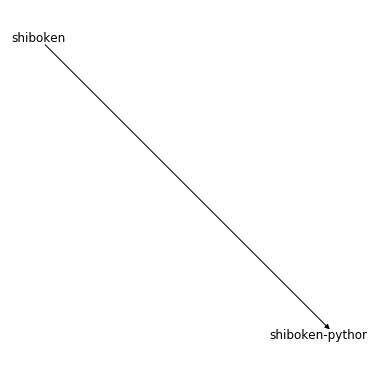

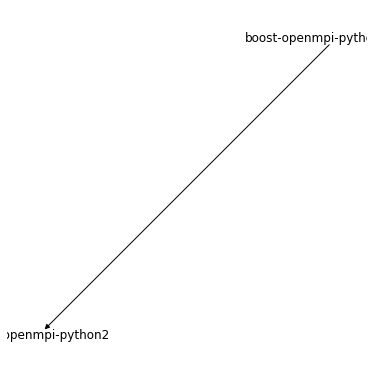

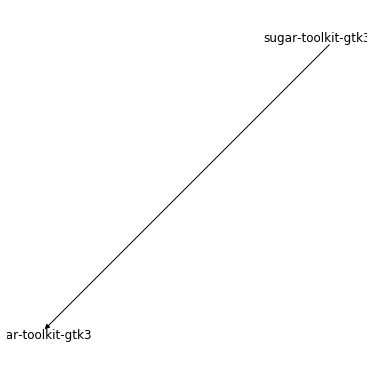

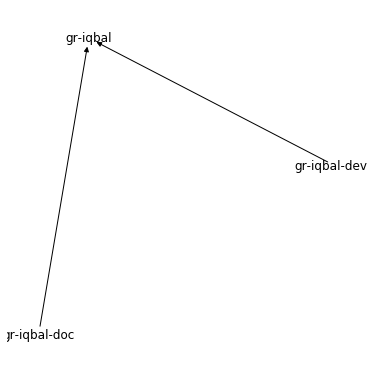

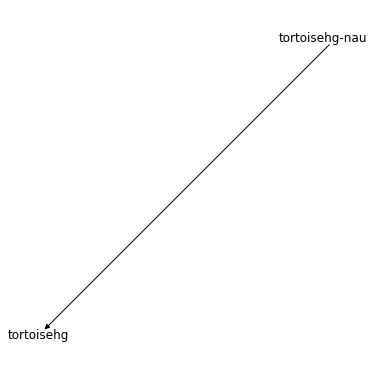

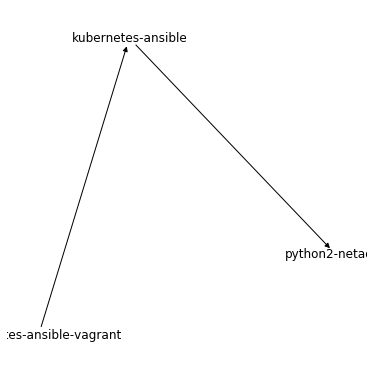

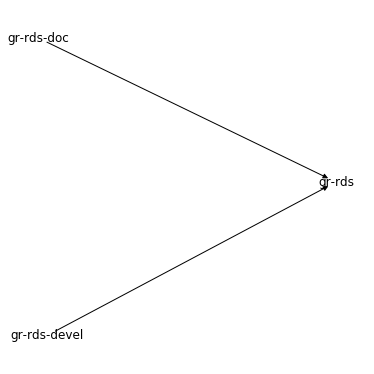

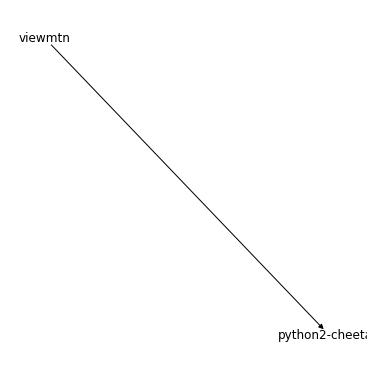

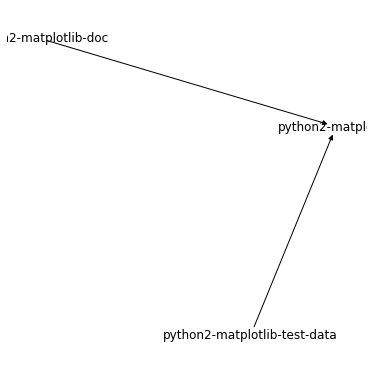

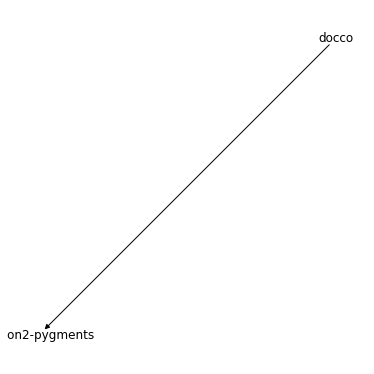

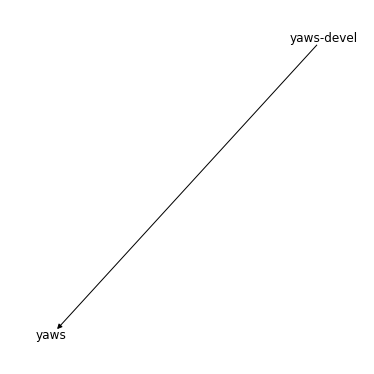

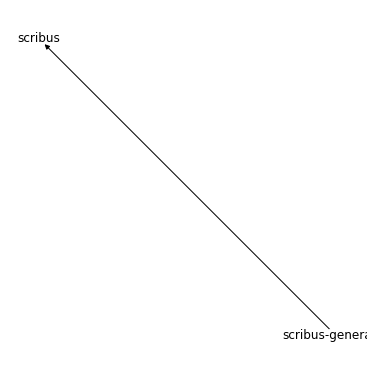

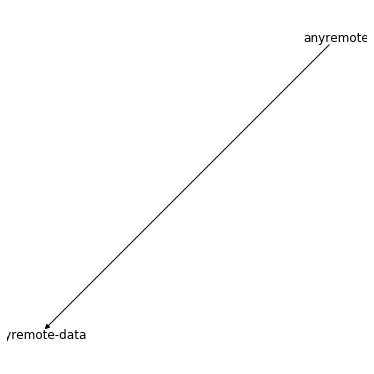

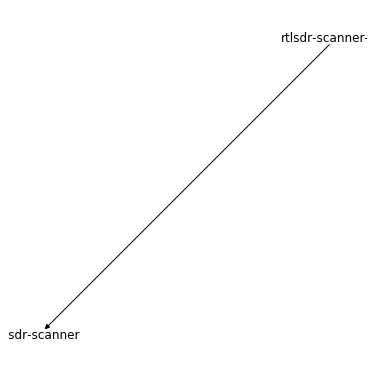

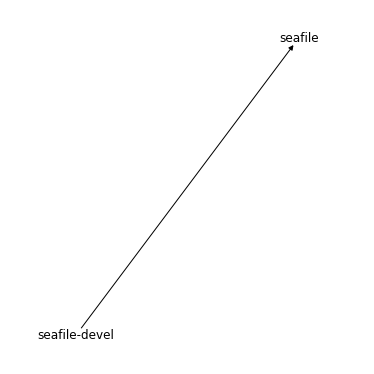

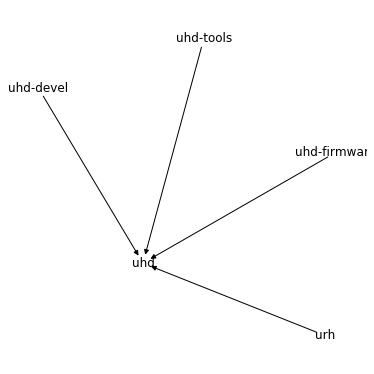

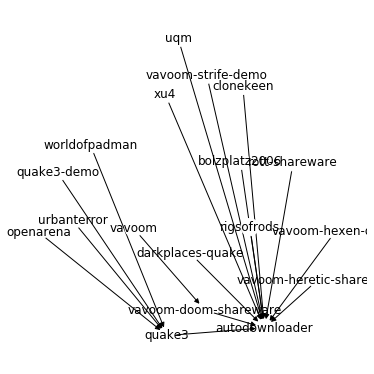

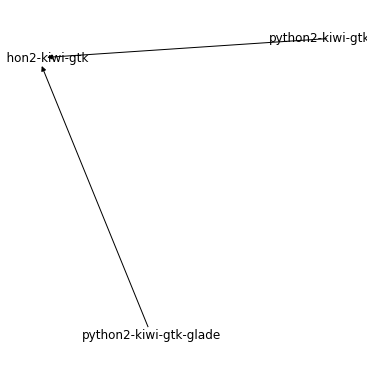

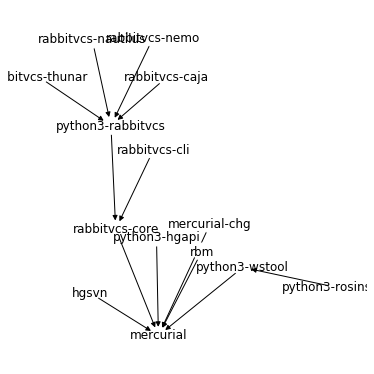

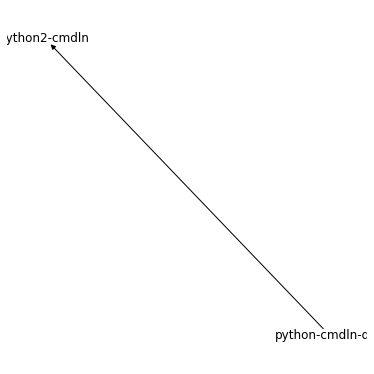

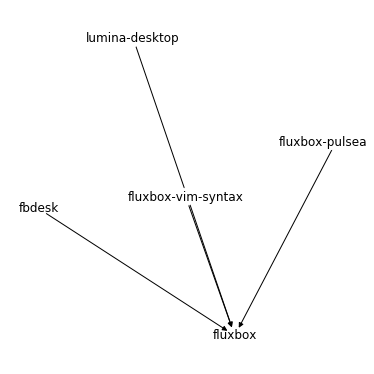

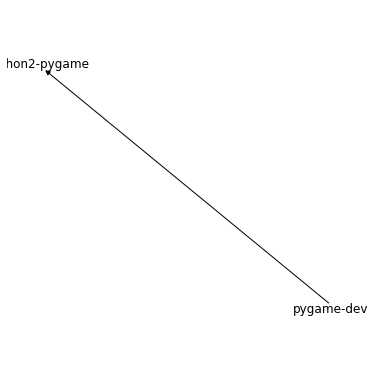

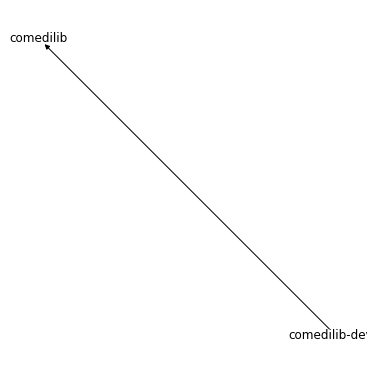

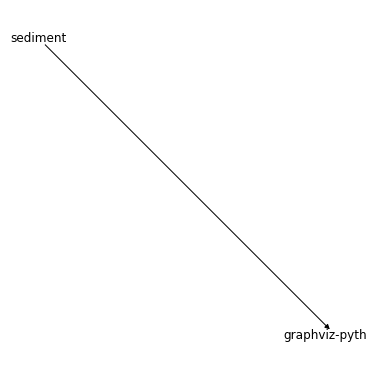

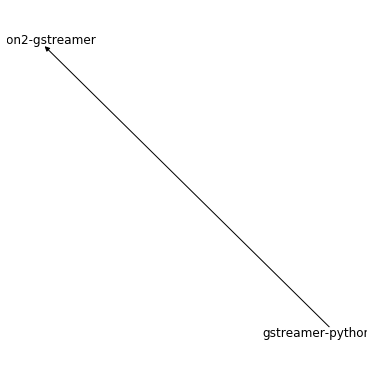

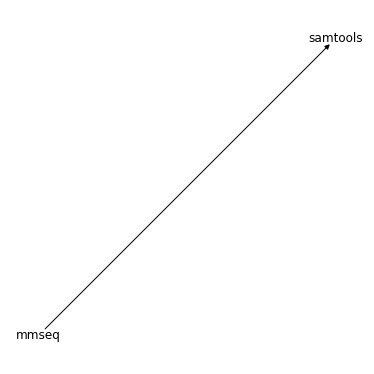

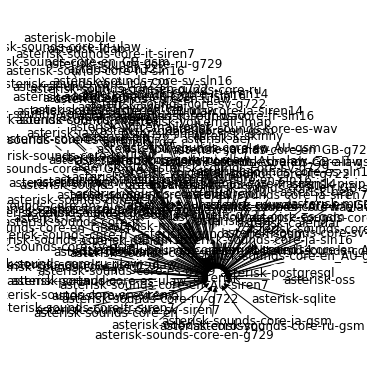

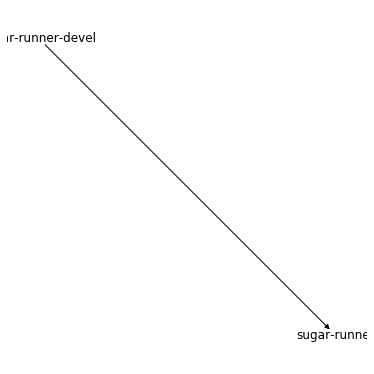

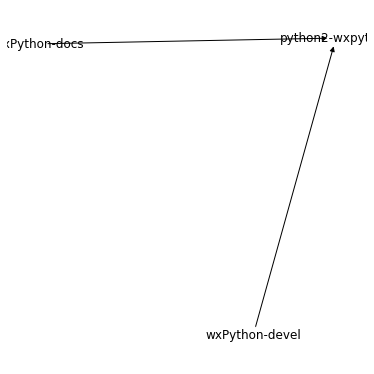

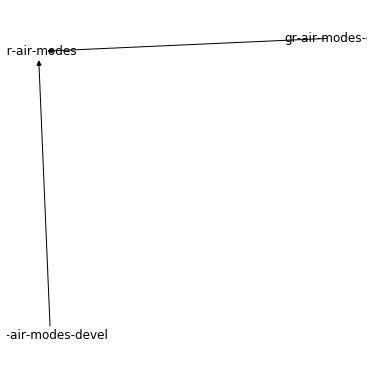

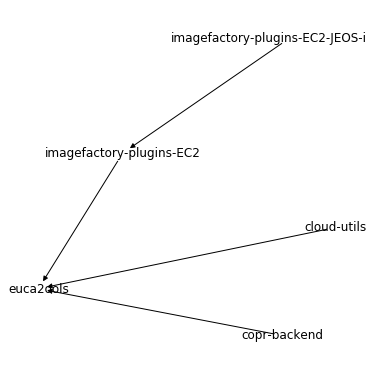

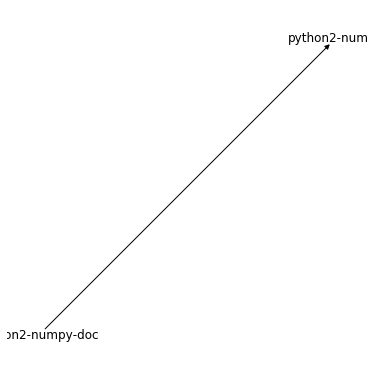

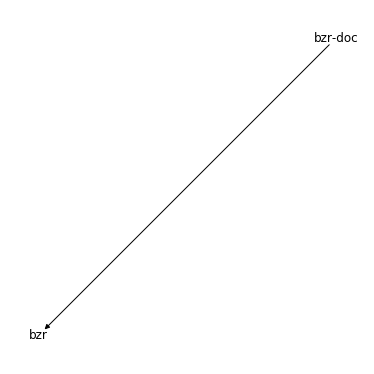

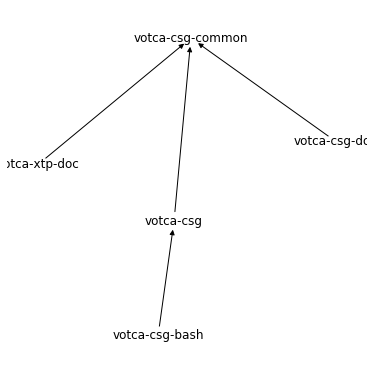

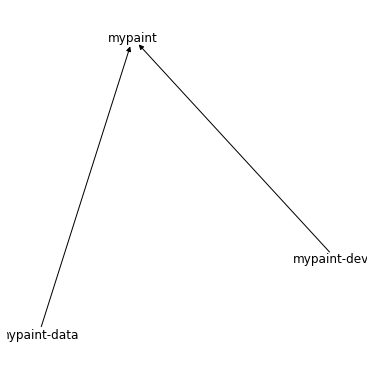

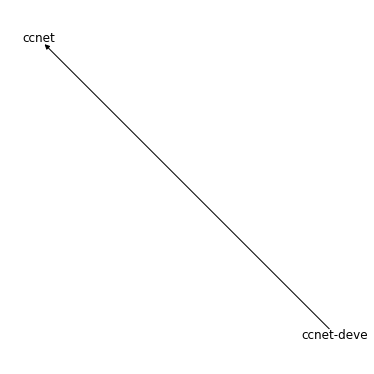

In [33]:
for sg in list(nx.weakly_connected_component_subgraphs(g_nc)):
    plt_draw(sg, figsize=(5,5))

## List of packages and theirs paths to Python 2

In [34]:
len(waves)

5

In [35]:
for n in range(len(waves),1,-1):
    for package in sorted(waves[str(n)]):
        print(f"{package} ({' → '.join(list(all_simple_paths(g, package, 'PYTHON2'))[0])})")

rabbitvcs-caja (rabbitvcs-caja → python3-rabbitvcs → rabbitvcs-core → mercurial → PYTHON2)
rabbitvcs-nautilus (rabbitvcs-nautilus → python3-rabbitvcs → rabbitvcs-core → mercurial → PYTHON2)
rabbitvcs-nemo (rabbitvcs-nemo → python3-rabbitvcs → rabbitvcs-core → mercurial → PYTHON2)
rabbitvcs-thunar (rabbitvcs-thunar → python3-rabbitvcs → rabbitvcs-core → mercurial → PYTHON2)
fawkes-devenv (fawkes-devenv → PyQt4-devel → python2-sip-devel → PYTHON2)
gr-iio-devel (gr-iio-devel → gnuradio-devel → gnuradio → PYTHON2)
ibus-input-pad (ibus-input-pad → input-pad → python2-gobject → PYTHON2)
iipsrv-httpd-fcgi (iipsrv-httpd-fcgi → iipsrv → macromilter → PYTHON2)
imagefactory-plugins-EC2-JEOS-images (imagefactory-plugins-EC2-JEOS-images → imagefactory-plugins-EC2 → euca2ools → PYTHON2)
input-pad-devel (input-pad-devel → input-pad → python2-gobject → PYTHON2)
kubernetes-ansible-vagrant (kubernetes-ansible-vagrant → kubernetes-ansible → python2-netaddr → PYTHON2)
netatalk-devel (netatalk-devel → neta

## List of all SRPMs and theirs RPMs

In [36]:
inverse_map = {}
for srpm, pkgs in mapping.items():
    inverse_map.update({pkg: srpm for pkg in pkgs})

In [37]:
srpms = defaultdict(list)
for n in range(len(waves),1,-1):
    for package in waves[str(n)]:
        try:
            srpm = inverse_map[package]
        except KeyError:
            srpm = "N/A"
        srpms[srpm].append(package)

for srpm, packages in sorted(srpms.items(), key=lambda x: x[0]):
    print(f"{srpm} maintainers: {', '.join(maintainers[srpm])}, RPMs: {', '.join(packages)}")

PyQt4 maintainers: than, rdieter, RPMs: PyQt4-devel
anyremote maintainers: orphan, RPMs: anyremote
asciidoc maintainers: jridky, tmz, sochotni, nphilipp, RPMs: asciidoc-music, asciidoc-latex
asterisk maintainers: itamarjp, russellb, jsmith, RPMs: asterisk-ael, asterisk-alembic, asterisk-alsa, asterisk-calendar, asterisk-corosync, asterisk-curl, asterisk-dahdi, asterisk-devel, asterisk-fax, asterisk-festival, asterisk-hep, asterisk-iax2, asterisk-ices, asterisk-ldap, asterisk-lua, asterisk-mgcp, asterisk-minivm, asterisk-misdn, asterisk-mobile, asterisk-mwi-external, asterisk-mysql, asterisk-odbc, asterisk-ooh323, asterisk-oss, asterisk-pjsip, asterisk-portaudio, asterisk-postgresql, asterisk-radius, asterisk-sip, asterisk-skinny, asterisk-snmp, asterisk-sqlite, asterisk-tds, asterisk-unistim, asterisk-voicemail, asterisk-voicemail-imap, asterisk-voicemail-odbc, asterisk-voicemail-plain
asterisk-sounds-core maintainers: itamarjp, jsmith, RPMs: asterisk-sounds-core-en, asterisk-sounds-co

In [39]:
"trac" in g_nc.nodes

False